# Multi step trajectory clustering

## Parameters

In [1]:
num_traj = 2_000
random_trajs = True
random_seed = 1234
data_path = "data/trajectories_nostokes_subset_10000.csv"

## Imports

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from lagtrajclust.data_loading import load_and_subset_trajectories_csv
from lagtrajclust.h3_trafo import (
    df_to_h3,
    h3_series_to_h3_parent,
    h3_series_to_series_of_h3_sequences,
    remove_subsequent_identical_elements,
)

from lagtrajclust.visualisation import polygonise_h3s

from lagtrajclust.clustering import dbscan_with_edist_metric

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Download and load data

In [4]:
# !mkdir -p data/
# !curl \
#     -o data/trajectories_nostokes_subset_10000.csv.gz \
#     https://zenodo.org/record/4650317/files/trajectories_nostokes_subset_10000.csv.gz
# !gunzip -f -v data/trajectories_nostokes_subset_10000.csv.gz

In [5]:
%%time

# load raw data
df = load_and_subset_trajectories_csv(file_name=data_path, num_traj=num_traj, use_random=random_trajs)

# add highest-resolution h3 ids
df["h3r15"] = df_to_h3(df, resolution=15)["h3"]

# have a look
display(df)

MPA    distance  land   latitude  longitude       temp  \
traj  obs                                                           
5     0    1.0    0.000000   0.0  43.271830   5.246235  13.516298   
      1    1.0    0.040199   0.0  43.272186   5.246135  13.515918   
      2    1.0    0.075564   0.0  43.272495   5.246029  13.515487   
      3    1.0    0.106174   0.0  43.272760   5.245916  13.515051   
      4    1.0    0.132164   0.0  43.272976   5.245798  13.514611   
...        ...         ...   ...        ...        ...        ...   
10005 957  0.0  675.977840   0.0  38.648613   2.072964  24.624964   
      958  0.0  676.702900   0.0  38.654305   2.077066  24.618725   
      959  0.0  677.426900   0.0  38.659966   2.081217  24.617500   
      960  0.0  678.151000   0.0  38.665596   2.085435  24.619713   
      961  0.0  678.211400   0.0  38.666065   2.085789  24.619965   

                         time          z            h3r15  
traj  obs                                                  
5     0   2017-03-12 00:00:00   7.920377  8f396811809dc19  
      1   2017-03-12 01:00:00   7.920377  8f3968118083075  
      2   2017-03-12 02:00:00   7.920377  8f3968118080241  
      3   2017-03-12 03:00:00   7.920377  8f39681180857b1  
      4   2017-03-12 04:00:00   7.920377  8f3968118085c62  
...                       ...        ...              ...  
10005 957 2017-07-04 21:00:00  10.536604  8f395175db72113  
      958 2017-07-04 22:00:00  10.536604  8f395174e7152a9  
      959 2017-07-04 23:00:00  10.536604  8f395174e058a74  
      960 2017-07-05 00:00:00  10.536604  8f395174eae0721  
      961 2017-07-05 00:00:00  10.536604  8f395174eae538b  

[1924000 rows x 9 columns]

CPU times: user 1min 29s, sys: 2.59 s, total: 1min 31s
Wall time: 1min 32s


## Coarsen data and transform

We coarsen (from the highest-resolution data), and transform to a series of lists of h3s without subsequent dupes.

In [15]:
h3_working_resolution = 2

In [16]:
%%time

h3_series = h3_series_to_h3_parent(df["h3r15"], resolution=h3_working_resolution)

h3_sequences = h3_series_to_series_of_h3_sequences(h3_series)

h3_sequences = remove_subsequent_identical_elements(h3_sequences)

CPU times: user 2.72 s, sys: 54 ms, total: 2.78 s
Wall time: 2.79 s


In [17]:
display(h3_sequences)

traj
5                       [82396ffffffffff, 823947fffffffff]
6                       [82396ffffffffff, 823947fffffffff]
7                                        [82396ffffffffff]
17       [82396ffffffffff, 823947fffffffff, 82396ffffff...
29       [82396ffffffffff, 823947fffffffff, 82396ffffff...
                               ...                        
9979     [823827fffffffff, 82382ffffffffff, 823957fffff...
9984                                     [823827fffffffff]
9992                                     [823827fffffffff]
9996     [823827fffffffff, 823837fffffffff, 823827fffff...
10005                   [823827fffffffff, 823957fffffffff]
Name: h3r15, Length: 2000, dtype: object

Check length distribution

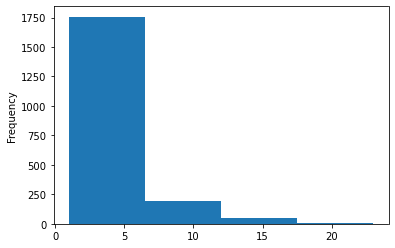

In [18]:
h3_lengths = h3_sequences.apply(len)
bin_number = int(np.log(5 * h3_lengths.max()))
h3_lengths.plot.hist(bins=bin_number);

## Do a clustering

In [19]:
%%time

cluster_ids = dbscan_with_edist_metric(h3_sequences, eps=0.3)

CPU times: user 1min 8s, sys: 67.1 ms, total: 1min 8s
Wall time: 1min 8s


<AxesSubplot:xlabel='traj'>

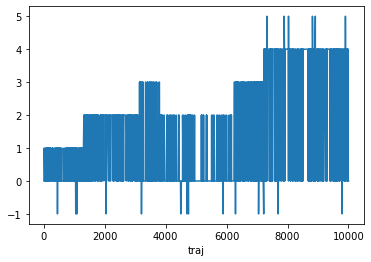

In [20]:
cluster_ids.plot()

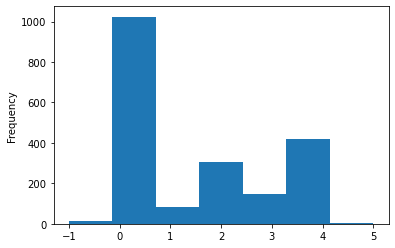

In [21]:
cluster_ids.plot.hist(bins=len(cluster_ids.unique()));

In [22]:
from functools import reduce
from operator import add

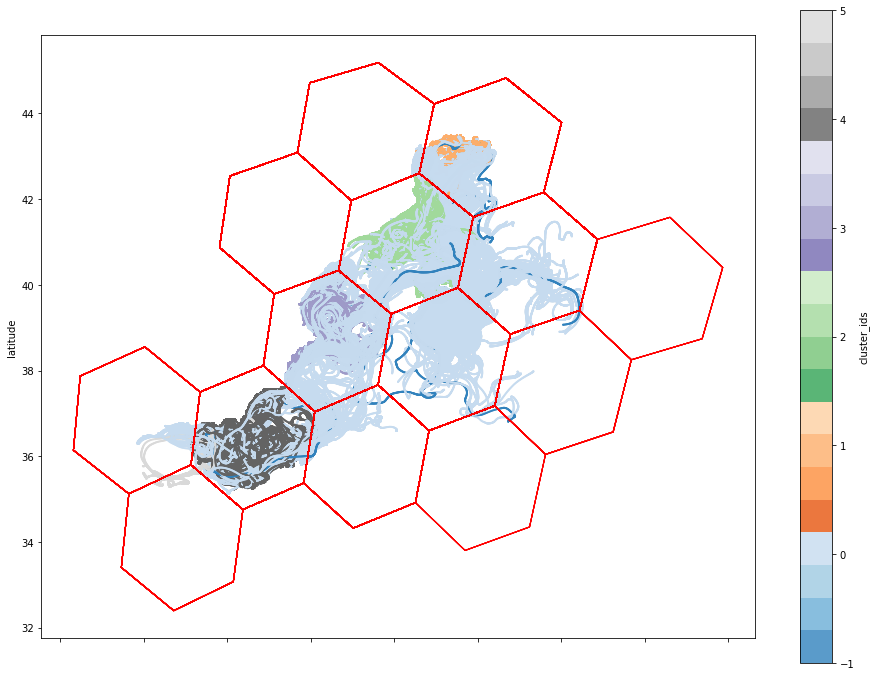

In [23]:
ax = df.join(cluster_ids.rename("cluster_ids")).plot.scatter(
    x="longitude", y="latitude", 
    c="cluster_ids", cmap="tab20c",
    s=1, alpha=0.8,
    figsize=(16, 12),
);
polygonise_h3s(reduce(add, h3_sequences)).plot(ax=ax, edgecolor='red', facecolor="none");